# IMPORT

In [1]:
try:
    import google.colab # type: ignore
    colab = True
except:
    colab = False

if colab:
    !git clone "https://github.com/cybernetic-m/eai-project.git" # type: ignore

In [2]:
# Model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR 

# Others
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
 
# Our files
if colab:
    sys.path.append('/content/eai-project/training')
    sys.path.append('/content/eai-project/preprocessing')
    sys.path.append('/content/eai-project/dataset')
    sys.path.append('/content/eai-project/utils')
    sys.path.append('/content/eai-project/models')
    sys.path.append('/content/eai-project/testing')
    from train import train
    from preprocessing import *
    from thermal_dataset import thermal_dataset 
    from utils import *
    from complete_model import complete_model 
    from lstm_only import lstm_only
    from testing import test
    prefix = '/content'
        
else:
    from training.train import train
    from preprocessing.preprocessing import *
    from dataset.thermal_dataset import thermal_dataset
    from utils.csv_utils import *
    from models.complete_model import complete_model
    from models.complete_model_autoencoder import complete_model_autoencoder
    from models.lstm_only import lstm_only
    from testing.test import test
    from blocks import mlp, linear, rnn, lstm, cnn
    prefix = '.'
    
pd.set_option('display.max_columns', None)

In [3]:
autoencoder_train = False # to train only the autoencoder

hyper_parameters = {'num_epochs': 100,
                    'batch_size': 256,
                    'hidden_dim' : 3,
                    'lr': 0.001,
                    'mode': 'auto-weighted', #average, mlp, linear, auto-weighted
                    'extractor_type': 'lstm', #lstm (if you want to use the lstm autoencoder), conv (if you want to use the convolutional autoencoder)
                    'ensemble': True,
                    'timesteps': 200,
                    'window_size':30,
                    'norm': 'Not', # Not (Raw Data), Minmax (MinMax Scaling), Std (Standard Scaling)
                    'file':1,
                    'weight_decay': 0,
                    'pretrain':False,
                    'heterogeneous': True,
                    'lr_multipliers_extractor': 0.1,
                    'lr_multipliers_ensemble': {
                        mlp: 10,
                        linear: 10,
                        rnn: 1,
                        lstm: 1,
                        cnn: 1
                    }

                        }

# Parameters of the convolutional autoencoder
conv_autoencoder_dict = {'in_kern_out': [[4, 3, 5], [5, 3, 6]], # List of hyperparam of autoencoder [[in_channels, kernel_size, out_channels], ...]
                    'pooling_kernel_size': 2, # how much big is the kernel of the pooling (i.e. 2 means halving the dimension each layer)
                    'padding': 'same', # 'same', 'full', 'valid'
                    'pooling': 'avg', # 'max' for Max Pooling and 'avg' for Average Pooling 
                    'scale_factor': 2, # upsample scale_factor, 2 means double the dimension each layer
                    'upsample_mode': 'linear', # mode of the upsampling 'linear', 'nearest'
                    'dropout': 0.0
 }

lstm_autoencoder_dict = {'in_hidd': [[4, 2]], # List of hyperparam of autoencoder [[input_dim, hidden_dim], ...]
                        'dropout': 0.75
 }


if hyper_parameters['extractor_type'] == 'conv':
    feature_dim = int(( hyper_parameters['timesteps'] / (2*(len(conv_autoencoder_dict['in_kern_out'])-1))*conv_autoencoder_dict['in_kern_out'][-1][-1]) /2)
    autoencoder_dict = conv_autoencoder_dict
elif hyper_parameters['extractor_type'] == 'lstm':
    feature_dim = hyper_parameters['timesteps']*lstm_autoencoder_dict['in_hidd'][-1][-1] 
    autoencoder_dict = conv_autoencoder_dict
if hyper_parameters['heterogeneous']:
    feature_dim += 3
    

# Definition of the model (You can decomment to include more models)
ensemble_model = {
    'mlp': [{'layer_dim_list': [ feature_dim,int(feature_dim/1.5),int(feature_dim/3),int(feature_dim/5),int(feature_dim/8),int(feature_dim/10),3]}],
            #{'layer_dim_list': [ feature_dim,int(feature_dim*1.5),3]}], 
    'ARIMA': [{'p': 2, 'd': 0, 'q': 2, 'ps': 0, 'ds': 0, 'qs': 0, 's': 1}], 
    #'linear_regressor': [{'in_features': feature_dim, 'out_features': 3, 'bias':False}],
    'lstm': [{'feature_dim':3, 'input_dim':feature_dim, 'num_layers':1}],
    #'rnn': [{'feature_dim':3, 'input_dim':feature_dim, 'num_layers':1}],
    #'cnn': [{'input_dim':hyper_parameters['hidden_dim'],
    #            'hidden_dim_list': [ int(feature_dim/10),int(feature_dim/20),int(feature_dim/30)],
    #            'output_dim': 3,
    #            'kernel_size_list':[2,4,2]
    #            }]
}

In [4]:
skip = False
test_flag = True

if os.path.exists(prefix+'/data/X'+'training'+str(hyper_parameters['file'])+'.npy') and os.path.exists(prefix+'/data/Y'+str(hyper_parameters['window_size'])+'training'+str(hyper_parameters['file'])+'.npy'):
    print("Data already exists!")
    print(prefix+'/data/X'+'training'+str(hyper_parameters['file'])+'.npy')
    print(prefix+'/data/Y'+str(hyper_parameters['window_size'])+'training'+str(hyper_parameters['file'])+'.npy')
    skip = True

**Reproducibility and Device Setting**

In [5]:
# Set a seed for reproducibility purposes
seed = 46
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# Set the device (cuda for Nvidia GPUs, mps for M1, M2 .. Apple Silicon)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# DATASET

In [6]:
link_zipped_csv = 'https://drive.google.com/file/d/1MssQF4pI_rZqiiDBP4XaLTT1ZaN6ykLm/view?usp=drive_link'
gdrive_link = 'https://drive.google.com/uc?id='
csv_dir = './csv'
zipped_file = './csv.zip'

download_csv(
    link_zipped_csv,
    gdrive_link,
    zipped_file
)

unzip_csv(
    zipped_file,
    csv_dir,
)


CSV file already downloaded!
CSV file already unzipped!


In [7]:
if not skip:

    path = '/content/csv/thermal_drift_features_lab_05_02.csv'

    # Read all the CSV files containing the Temperatures
    features_1 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_features_lab_05_02.csv'))
    features_2 = pd.read_csv(os.path.join(prefix, 'csv/thermal_drift_features_lab_05_03.csv'))
    features_3 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_features_lab_05_04.csv'))
    features_4 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_features_lab_05_05.csv'))
    features_5 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_features_lab_05_06.csv'))

    # Read all the CSV files containing the X1, Y1, Z1 
    targets_1 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_02.csv'))
    targets_2 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_03.csv'))
    targets_3 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_04.csv'))
    targets_4 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_05.csv'))
    targets_5 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_06.csv'))

    features = [features_1, features_2, features_3, features_4, features_5]
    targets = [targets_1,targets_2,targets_3,targets_4,targets_5]

In [8]:
if not skip:
    for feature, target in zip(features, targets):
        feature.drop([
            "name", "tags",
            "2\"Tray1 Vacuum Sensor", "2\"Tray2 Vacuum Sensor", "2\"Tray3 Vacuum Sensor",
            "Avg Oven Temperature", "Chuck Temp [Cdeg]", "Chuck Temp2 [Cdeg]",
            "Chuck1 Vacuum Sensor", "Contrast", "Device State",
            "Dispenser1 Pressure Sensor", "Machine Room Temp", "Main Air", "Main Vacuum",
            "Oven Temperature", "PE_Rx", "PE_Ry", "PE_Rz", "PE_X1", "PE_Y1", "PE_Z1",
            "PUT1 Flow Sensor", "PUT2 Flow Sensor1", "PUT2 Flow Sensor2",
            "PUT2 Flow Sensor3", "PUT2 Flow Sensor4", "PUT2 Flow Sensor5",
            "Photodiode", "Pixel Power", "Preciser1 Vacuum Sensor",
            "Tec FIB1 Holder", "Tec FIB1 Plate", "Tec FIB2 Holder", "Tec FIB2 Plate",
            "Torque11","Torque2","Torque3","Torque4","Torque5","Torque6"
        ], axis=1, inplace=True)
        if 'name' in target.keys() and 'tags' in target.keys():

            target.drop(['name', 'tags'], axis=1, inplace=True)
            
            


In [9]:
if not skip:
    print(features[1]) # Print the features_1 table

                        time  Temp Sensor 1  Temp Sensor 2  Temp Sensor 3  \
0        1714687200035019000           2104           2137           2145   
1        1714687200090637000           2104           2137           2145   
2        1714687200177338000           2104           2137           2145   
3        1714687200228517000           2104           2137           2145   
4        1714687200279903000           2104           2137           2145   
...                      ...            ...            ...            ...   
1248011  1714773599360645000           2097           2139           2131   
1248012  1714773599473292000           2097           2139           2131   
1248013  1714773599580569000           2097           2139           2131   
1248014  1714773599762038000           2097           2139           2131   
1248015  1714773599869383000           2097           2139           2131   

         Temp Sensor 4  
0                 2157  
1                 2157  


In [10]:
if not skip:

    print(targets[1]) # Print the target_1

                      time            X1            Y1            Z1
0      1714687207558354000 -42505.406213           NaN           NaN
1      1714687207564731000           NaN  44826.890179           NaN
2      1714687207615696000           NaN           NaN  12929.179688
3      1714687218845182000 -42505.413769           NaN           NaN
4      1714687218860796000           NaN  44826.885132           NaN
...                    ...           ...           ...           ...
23104  1714773578301848000           NaN  44833.645142           NaN
23105  1714773578313892000           NaN           NaN  12927.773438
23106  1714773589691570000 -42506.334704           NaN           NaN
23107  1714773589700556000           NaN  44833.606733           NaN
23108  1714773589724371000           NaN           NaN  12927.734375

[23109 rows x 4 columns]


In [11]:
if not skip:
    # Put X1, Y1, Z1 on the same row of X1 eliminating the NAN values
    fixed_targets = [] # Create a list of target in which we put X1, Y1, Z1 in the same row
    for target in targets:
        fixed_targets.append(transform_dataframe(target)) # iterate over target_1,2,3 ... and append in fixed_targets
        
        

In [12]:
if not skip:

    print(fixed_targets[1]) # Print the fixed_target_1

              time            X1            Y1            Z1
0     1.714687e+18 -42505.406213  44826.890179  12929.179688
1     1.714687e+18 -42505.413769  44826.885132  12929.218750
2     1.714687e+18 -42505.422058  44826.895999  12929.257812
3     1.714687e+18 -42505.400897  44826.871417  12929.257812
4     1.714687e+18 -42505.411462  44826.871253  12929.218750
...            ...           ...           ...           ...
7698  1.714774e+18 -42506.297617  44833.632677  12927.812500
7699  1.714774e+18 -42506.324153  44833.685632  12927.773438
7700  1.714774e+18 -42506.305219  44833.653979  12927.812500
7701  1.714774e+18 -42506.318353  44833.645142  12927.773438
7702  1.714774e+18 -42506.334704  44833.606733  12927.734375

[7703 rows x 4 columns]


In [13]:
if not skip:
    # Merge of targets with features in one single dataframe
    complete_numbers_list = [] # List of the table with columns that are numbers (0,1,2..) in which we unify both features and targets merging on closest time row
    for fixed_target, feature in zip(fixed_targets, features):
        complete_numbers_list.append(merge_on_closest_time(fixed_target.reset_index(), feature.reset_index()))

    trainig_number_list = []
    testing_number_list = []
    for i in range(len(complete_numbers_list)):
        part_numbers_list = complete_numbers_list[:i] + complete_numbers_list[i+1:]
        trainig_number_list.append(pd.concat(part_numbers_list))
        testing_number_list.append(complete_numbers_list[i])
        
    complete_numbers_dataframe = pd.concat(complete_numbers_list)
    


In [14]:
if not skip: 
    print(complete_numbers_list) # Print of one example

[        0                             1             2             3   \
0        0 2024-05-02 09:00:01.106507008 -42506.390100  44830.277517   
1        1 2024-05-02 09:00:12.382008064 -42506.368407  44830.177972   
2        2 2024-05-02 09:00:23.632736000 -42506.327086  44830.179741   
3        3 2024-05-02 09:00:34.970393088 -42506.308733  44830.136638   
4        4 2024-05-02 09:00:46.143995904 -42506.280652  44830.203599   
...    ...                           ...           ...           ...   
4166  4166 2024-05-02 21:59:11.262568960 -42505.368696  44826.901348   
4167  4167 2024-05-02 21:59:22.587275008 -42505.378471  44826.886557   
4168  4168 2024-05-02 21:59:33.874593024 -42505.419544  44826.930953   
4169  4169 2024-05-02 21:59:45.187085056 -42505.381234  44826.952204   
4170  4170 2024-05-02 21:59:56.406018048 -42505.364203  44826.906375   

                4       5                          6     7     8     9     10  
0     12931.601562       7 2024-05-02 09:00:01.084386 

In [15]:
if not skip:

    complete = complete_numbers_dataframe.rename(columns={
        0: 'id',
        1: 'time',
        2: 'X1',
        3: 'Y1',
        4: 'Z1',
        5: 'to_remove',
        6: 'time_2',
        7: 'Temp1',
        8: 'Temp2',
        9: 'Temp3',
        10: 'Temp4'
        })
    complete.drop(['time', 'to_remove', 'time_2'], axis=1, inplace=True)
    training_list = []
    testing_list = []
    for training, testing in zip(trainig_number_list, testing_number_list):
        training_tmp = training.rename(columns={
            0: 'id',
            1: 'time',
            2: 'X1',
            3: 'Y1',
            4: 'Z1',
            5: 'to_remove',
            6: 'time_2',
            7: 'Temp1',
            8: 'Temp2',
            9: 'Temp3',
            10: 'Temp4'
            })
        training_tmp.drop(['time', 'to_remove', 'time_2'], axis=1, inplace=True)
        training_list.append(training_tmp)
        
        testing_tmp = testing.rename(columns={
            0: 'id',
            1: 'time',
            2: 'X1',
            3: 'Y1',
            4: 'Z1',
            5: 'to_remove',
            6: 'time_2',
            7: 'Temp1',
            8: 'Temp2',
            9: 'Temp3',
            10: 'Temp4'
            })
        testing_tmp.drop(['time', 'to_remove', 'time_2'], axis=1, inplace=True)
        testing_list.append(testing_tmp)
        

In [16]:
if not skip:

    print(training_list)

[        id            X1            Y1            Z1  Temp1  Temp2  Temp3  \
0        0 -42505.406213  44826.890179  12929.179688   2103   2134   2145   
1        1 -42505.413769  44826.885132  12929.218750   2103   2129   2146   
2        2 -42505.422058  44826.895999  12929.257812   2103   2130   2147   
3        3 -42505.400897  44826.871417  12929.257812   2103   2133   2146   
4        4 -42505.411462  44826.871253  12929.218750   2103   2134   2146   
...    ...           ...           ...           ...    ...    ...    ...   
3095  3095 -42505.001668  44831.017452  12931.679688   2125   2168   2150   
3096  3096 -42505.022450  44831.051054  12931.679688   2125   2170   2149   
3097  3097 -42505.032772  44831.042085  12931.640625   2125   2174   2151   
3098  3098 -42504.992528  44831.031331  12931.679688   2125   2172   2150   
3099  3099 -42505.008199  44831.068524  12931.601562   2125   2172   2151   

      Temp4  
0      2159  
1      2158  
2      2157  
3      2158  
4   

In [17]:

if not skip:
    
    # Save the features and targets in file npy
    for i, (testing, training) in enumerate(zip(testing_list, training_list)):

        # Transform the training and test data in float
        training.astype(float) 
        testing.astype(float) 

        # Take from dataframe the values of the columns of temperatures and positions saving into smallest dataframe of training/test
        X_train = training[['Temp1','Temp2', 'Temp3', 'Temp4']] 
        Y_train = training[['X1', 'Y1', 'Z1']] 
        X_test = testing[['Temp1','Temp2', 'Temp3', 'Temp4']] 
        Y_test = testing[['X1', 'Y1', 'Z1']] 

        # Transform the X, Y from dataframe in numpy array both for test and train
        X_train = X_train.values.astype(np.float32) 
        Y_train = Y_train.values.astype(np.float32) 
        X_test = X_test.values.astype(np.float32) 
        Y_test = Y_test.values.astype(np.float32) 

        # Do the gradient of the positions both for test and train
        Y_train = my_gradient(Y_train, window_size=hyper_parameters['window_size']) 
        Y_test = my_gradient(Y_test, window_size=hyper_parameters['window_size']) 
 
        '''
        # Apply the scaling
        if hyper_parameters['norm'] != 'Not':
            if hyper_parameters['norm'] == 'Minmax':
                scaler = MinMaxScaler()
            elif hyper_parameters['norm'] == 'Std':
                scaler = StandardScaler()

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)
            Y_train = scaler.fit_transform(Y_train)
            Y_test = scaler.fit_transform(Y_test)
        else:
            print("Using Raw Data!")
    '''
    
        '''
        # Save the features and targets in file npy
        np.save(prefix+'/data'+'/X'+'training'+str(i)+str(hyper_parameters['norm'])+'.npy',X_train)  
        np.save(prefix+'/data'+'/Y'+str(hyper_parameters['window_size'])+'training'+str(i)+str(hyper_parameters['norm'])+'.npy',Y_train)
        np.save(prefix+'/data'+'/X'+'testing'+str(i)+str(hyper_parameters['norm'])+'.npy',X_test)
        np.save(prefix+'/data'+'/Y'+str(hyper_parameters['window_size'])+'testing'+str(i)+str(hyper_parameters['norm'])+'.npy',Y_test)
'''

np.save(prefix+'/data'+'/X'+'training'+str(i)+'.npy',X_train)  
np.save(prefix+'/data'+'/Y'+str(hyper_parameters['window_size'])+'training'+str(i)+'.npy',Y_train)
np.save(prefix+'/data'+'/X'+'testing'+str(i)+'.npy',X_test)
np.save(prefix+'/data'+'/Y'+str(hyper_parameters['window_size'])+'testing'+str(i)+'.npy',Y_test)

errors: 0
errors: 0
Using Raw Data!
errors: 0
errors: 0
Using Raw Data!
errors: 0
errors: 0
Using Raw Data!
errors: 0
errors: 0
Using Raw Data!
errors: 0
errors: 0
Using Raw Data!


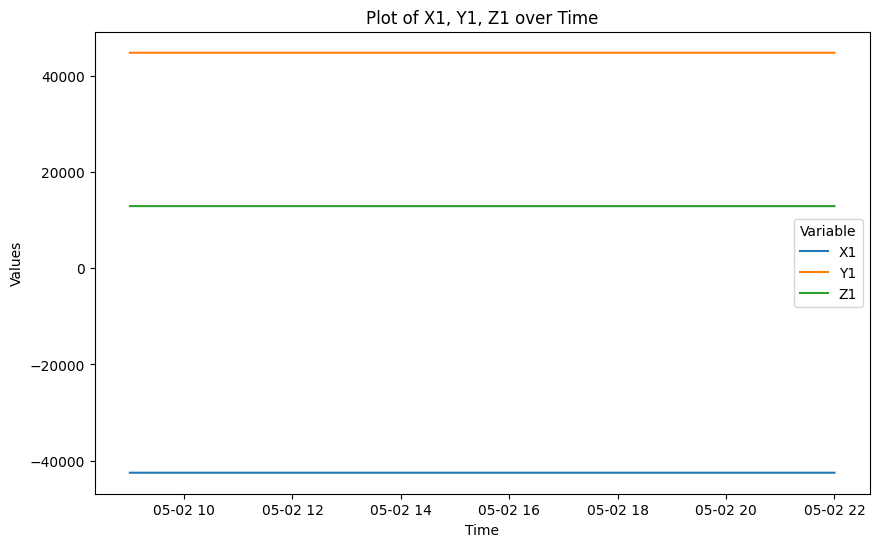

In [18]:
if not skip:

    targets_1['time'] = pd.to_datetime(targets_1['time'], unit='ns')

    # Reshape the DataFrame using melt()
    targets_melted = targets_1.reset_index().melt(id_vars=['time'], value_vars=['X1', 'Y1', 'Z1'], var_name='variable', value_name='value')

    # Drop rows where 'value' is NaN (to keep only the non-null entries)
    targets_melted = targets_melted.dropna(subset=['value'])

    # Plot the data
    plt.figure(figsize=(10, 6))
    for var in targets_melted['variable'].unique():
        # Filter data for each variable and plot
        temp_df = targets_melted[targets_melted['variable'] == var]
        plt.plot(temp_df['time'], temp_df['value'], label=var)

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Plot of X1, Y1, Z1 over Time')
    plt.legend(title='Variable')

    # Show the plot
    plt.show()

    #targets.plot(y='X1',x='time')

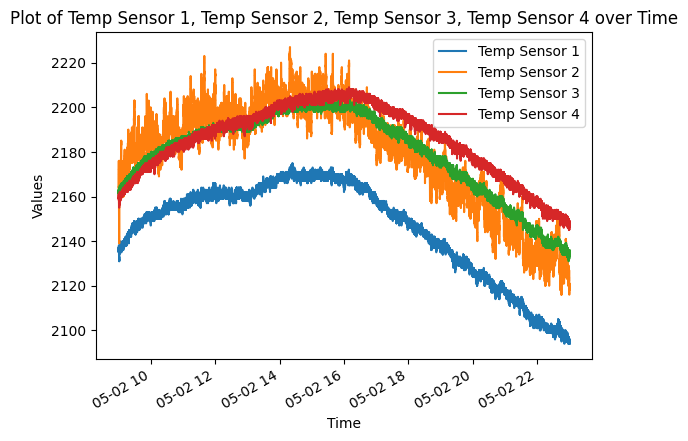

In [19]:
if not skip:

    # Convert 'time' to datetime (nanoseconds to datetime)
    features_1['time'] = pd.to_datetime(features_1['time'], unit='ns')

    # Set 'time' as the index
    features_1.set_index('time', inplace=True)

    # Optionally, you can plot X1, Y1, Z1 directly
    features_1[['Temp Sensor 1', 'Temp Sensor 2', 'Temp Sensor 3', 'Temp Sensor 4', ]].plot()

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Plot of Temp Sensor 1, Temp Sensor 2, Temp Sensor 3, Temp Sensor 4 over Time')

    # Show the plot
    plt.show()

In [20]:
'''
X = np.load(prefix+'/data'+'/X'+'training'+str(hyper_parameters['file'])+str(hyper_parameters['norm'])+'.npy')
Y = np.load(prefix+'/data'+'/Y'+str(hyper_parameters['window_size'])+'training'+str(hyper_parameters['file'])+str(hyper_parameters['norm'])+'.npy')
'''

X = np.load(prefix+'/data'+'/X'+'training'+str(hyper_parameters['file'])+'.npy')
Y = np.load(prefix+'/data'+'/Y'+str(hyper_parameters['window_size'])+'training'+str(hyper_parameters['file'])+'.npy')

print(X)
print(Y)

splitPerc = [0.7,0.3]
splitted_X = split(X, splitPerc)
splitted_Y = split(Y, splitPerc)

[[2136. 2164. 2163. 2159.]
 [2136. 2170. 2162. 2160.]
 [2136. 2176. 2163. 2160.]
 ...
 [2125. 2174. 2151. 2148.]
 [2125. 2172. 2150. 2150.]
 [2125. 2172. 2151. 2148.]]
[[0.00404703 0.00516981 0.01676342]
 [0.00302419 0.00579724 0.01880562]
 [0.00214214 0.00628737 0.01943131]
 ...
 [0.00369768 0.00781685 0.00424082]
 [0.00364815 0.00787941 0.00449284]
 [0.00362556 0.00819661 0.0044407 ]]
0
15880
0
15859


# MODEL

In [21]:
datasetTrain = thermal_dataset((splitted_X[0],splitted_Y[0]), hyper_parameters['timesteps'], device)
datasetVal = thermal_dataset((splitted_X[1],splitted_Y[1]), hyper_parameters['timesteps'], device)

In [22]:
# Training, Test and Validation Dataloader initialization
loaderTrain = DataLoader(datasetTrain, shuffle=True, batch_size=hyper_parameters['batch_size'])
loaderVal = DataLoader(datasetVal, shuffle=True, batch_size=hyper_parameters['batch_size'])

# Model Initialization (True if you want to use the Ensemble model, False in you want to use a single LSTM model)
if hyper_parameters['ensemble'] == False:
    model = lstm_only(hidden_dim=hyper_parameters['hidden_dim'],
                      timesteps=hyper_parameters['timesteps'] ,
                      input_dim=4, 
                      output_dim=3).to(device)
    
elif hyper_parameters['ensemble'] == True:
    if hyper_parameters['extractor_type'] == 'conv':
        model = complete_model_autoencoder(ensemble_model, 
                                           device, 
                                           autoencoder_dim=conv_autoencoder_dict['in_kern_out'], 
                                           pooling_kernel_size=conv_autoencoder_dict['pooling_kernel_size'], 
                                           padding=conv_autoencoder_dict['padding'], 
                                           pooling=conv_autoencoder_dict['pooling'], 
                                           scale_factor = conv_autoencoder_dict['scale_factor'], 
                                           upsample_mode=conv_autoencoder_dict['upsample_mode'], 
                                           dropout=conv_autoencoder_dict['dropout'],
                                           mode=hyper_parameters['mode'],
                                           heterogeneous=hyper_parameters['heterogeneous'],
                                           timesteps=hyper_parameters['timesteps'],
                                           norm=hyper_parameters['norm']
                                           ).to(device)
    
    elif hyper_parameters['extractor_type'] == 'lstm':
        model = complete_model_autoencoder(
                                    model_dict=ensemble_model, 
                                    device=device, 
                                    timesteps=hyper_parameters['timesteps'],
                                    autoencoder_dim=lstm_autoencoder_dict['in_hidd'], 
                                    dropout=lstm_autoencoder_dict['dropout'],
                                    extractor_type=hyper_parameters['extractor_type'],
                                    heterogeneous=hyper_parameters['heterogeneous'],
                                    norm=hyper_parameters['norm']
                                    ).to(device)
    else:
        model = complete_model(
                               hidden_dim=hyper_parameters['hidden_dim'], 
                               input_dim=4, 
                               model_dict=ensemble_model, 
                               device=device, 
                               mode=hyper_parameters['mode'], 
                               extractor_type=hyper_parameters['extractor_type']
                               ).to(device)

# Definition of the optimizer and loss function

if hyper_parameters['ensemble'] == False:
    optimizer = optim.Adam(model.parameters(), lr=hyper_parameters['lr'])
elif hyper_parameters['ensemble'] == True:


    models, arima, rnn_ = model.get_models()
    list_models = models + arima + rnn_ 
    optimizer = [optim.Adam(model.extractor.parameters(), lr=hyper_parameters['lr']*hyper_parameters['lr_multipliers_extractor'])]
    for sub_model in list_models: 
        for model_type, multiplier in hyper_parameters['lr_multipliers_ensemble'].items():
            if isinstance(sub_model, model_type):
                optimizer.append(optim.Adam(model.parameters(), lr=hyper_parameters['lr']*multiplier, weight_decay=hyper_parameters['weight_decay']))
                break
    print(len(optimizer))

hyper_parameters['lr_multipliers_ensemble'] = {
        'mlp': hyper_parameters['lr_multipliers_ensemble'][mlp],
        'linear': hyper_parameters['lr_multipliers_ensemble'][linear],
        'rnn': hyper_parameters['lr_multipliers_ensemble'][rnn],
        'lstm': hyper_parameters['lr_multipliers_ensemble'][lstm],
        'cnn': hyper_parameters['lr_multipliers_ensemble'][cnn]
    }


loss_fn = nn.MSELoss()
if hyper_parameters['ensemble'] == False:
    scheduler = ExponentialLR(optimizer, gamma=0.85)
elif hyper_parameters['ensemble'] == True:
    scheduler = [ExponentialLR(opti, gamma=0.85) for opti in optimizer]
model

Autoencoder type: LSTM
3


/Users/cyber_m/Desktop/EAI-1/eai-project/.venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn(


Ensemble Model Summary: ModuleList(
  (0): mlp(
    (linear_layers): ModuleList(
      (0): Linear(in_features=403, out_features=268, bias=True)
      (1): Linear(in_features=268, out_features=134, bias=True)
      (2): Linear(in_features=134, out_features=80, bias=True)
      (3): Linear(in_features=80, out_features=50, bias=True)
      (4): Linear(in_features=50, out_features=40, bias=True)
      (5): Linear(in_features=40, out_features=3, bias=True)
    )
  )
) ModuleList(
  (0): ARIMA(
    (PD): TwoPolynomialOperation(
      (first_poly): BiasOnePolynomial()
      (second_poly): Polynomial()
    )
    (Q): BiasOnePolynomial()
    (PDS): TwoPolynomialOperation(
      (first_poly): BiasOnePolynomial()
      (second_poly): Polynomial()
    )
    (QS): BiasOnePolynomial()
  )
) ModuleList(
  (0): lstm(
    (lstm): LSTM(403, 3, batch_first=True)
  )
)
3


complete_model_autoencoder(
  (extractor): lstm_autoencoder(
    (encoder): lstm_encoder(
      (lstm_layers): ModuleList(
        (0): lstm(
          (lstm): LSTM(4, 2, batch_first=True, dropout=0.75)
        )
      )
    )
    (decoder): lstm_decoder(
      (lstm_layers): ModuleList(
        (0): lstm(
          (lstm): LSTM(2, 4, batch_first=True, dropout=0.75)
        )
      )
      (linear_decoder): Linear(in_features=800, out_features=800, bias=True)
    )
  )
  (ensemble): ensemble_model(
    (models): ModuleList(
      (0): mlp(
        (linear_layers): ModuleList(
          (0): Linear(in_features=403, out_features=268, bias=True)
          (1): Linear(in_features=268, out_features=134, bias=True)
          (2): Linear(in_features=134, out_features=80, bias=True)
          (3): Linear(in_features=80, out_features=50, bias=True)
          (4): Linear(in_features=50, out_features=40, bias=True)
          (5): Linear(in_features=40, out_features=3, bias=True)
        )
      )

In [23]:
if hyper_parameters['pretrain']:
    model.load('./results/training_2025-02-25_17-35/autoencoder.pt',autoencoder=hyper_parameters['pretrain'])

train(
    num_epochs=hyper_parameters['num_epochs'],
    loss_fn=loss_fn,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    training_dataloader=loaderTrain,
    validation_dataloader=loaderVal,
    hyperparams=hyper_parameters,
    model_dict = ensemble_model,
    autoencoder_dict=autoencoder_dict,
    complete=hyper_parameters['ensemble'],
    autoencoder_train=autoencoder_train
)


EPOCH 1/100:
Model saved to results/training_2025-03-04_12-01/model.pt
Weights of the Ensemble models: [1.000000013351432e-10, 1.0, 1.000000013351432e-10]
train MODEL: LOSS 0.040762823656 MAE X1:0.0003, Y1:0.0004, Z1:0.0005 R2 X1:0.9796, Y1:0.9892, Z1:0.9742 RMSE X1:0.000371, Y1:0.001203, Z1:0.000775
train AUTOENCODER: LOSS 3570489.717741935514 MAE temp1:1856.1867, temp2:1893.2056, temp3:1889.7722, temp4:1535.3087 R2 temp1:-6367.6925, temp2:-6330.1049, temp3:-7297.4468, temp4:-7600.6606 RMSE temp1:1866.350035, temp2:1903.194693, temp3:1899.749552, temp4:1535.409710
valid MODEL: LOSS 0.000094807048 MAE X1:0.0002, Y1:0.0003, Z1:0.0004 R2 X1:0.9766, Y1:0.9868, Z1:0.9777 RMSE X1:0.000315, Y1:0.000412, Z1:0.000501
valid AUTOENCODER: LOSS 2321395.490384615492 MAE temp1:1494.7329, temp2:1534.8862, temp3:1528.6443, temp4:1535.3087 R2 temp1:-5861.3410, temp2:-5162.3225, temp3:-6915.3718, temp4:-7600.6606 RMSE temp1:1494.860364, temp2:1535.034831, temp3:1528.754851, temp4:1535.409710
EPOCH 2/100

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1035ece80>>
Traceback (most recent call last):
  File "/Users/cyber_m/Desktop/EAI-1/eai-project/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
